# Introduction to Packages

**Robert** how about a few lines on Pkg.add(), using, and import here?

In [1]:
Pkg.add("DataFrames")

Pkg.add("Plots")
Pkg.add("PyPlot")
Pkg.add("StatPlots")

Pkg.add("JuMP")
Pkg.add("Cbc")

INFO: Package DataFrames is already installed
INFO: Package Plots is already installed
INFO: Package PyPlot is already installed
INFO: Package StatPlots is already installed
INFO: Package JuMP is already installed
INFO: Package Cbc is already installed


# Creating an index fund

The goal of this project is the definition of an index fund, following the Dow Jones. That is, we want to select few stocks of the index, together with weights, that show a similar behavior to the overall index.

We start with price data of all the Dow Jones stocks from 2016. From the averages prices, we define weights of the stocks to be used

## Loading the price data

The data is provided in a file using comma-separated values and three columns:

In [2]:
;head dowjones2016.csv

date,symbol,price
2016-01-04,AAPL,105.349997999999999
2016-01-04,AXP,67.589995999999999
2016-01-04,BA,140.500000000000000
2016-01-04,CAT,67.989998000000000
2016-01-04,CSCO,26.410000000000000
2016-01-04,CVX,88.849997999999999
2016-01-04,DD,63.070000000000000
2016-01-04,DIS,102.980002999999996
2016-01-04,GE,30.709999000000000


Julia provides a function to read csv files into arrays:

In [3]:
?readcsv

search: readcsv readchomp @threadcall



```
readcsv(source, [T::Type]; options...)
```

Equivalent to [`readdlm`](@ref) with `delim` set to comma, and type optionally defined by `T`.


In [4]:
data = readcsv("dowjones2016.csv");
data[1:5,:]

5×3 Array{Any,2}:
 "date"        "symbol"     "price"
 "2016-01-04"  "AAPL"    105.35    
 "2016-01-04"  "AXP"      67.59    
 "2016-01-04"  "BA"      140.5     
 "2016-01-04"  "CAT"      67.99    

But we will use the DataFrames package for easier processing.

In [5]:
using DataFrames

In [6]:
?readtable

search: readtable



Read data from a tabular-file format (CSV, TSV, ...)

```julia
readtable(filename, [keyword options])
```

### Arguments

  * `filename::AbstractString` : the filename to be read

### Keyword Arguments

  * `header::Bool` – Use the information from the file's header line to determine column names. Defaults to `true`.
  * `separator::Char` – Assume that fields are split by the `separator` character. If not specified, it will be guessed from the filename: `.csv` defaults to `','`, `.tsv` defaults to `'	'`, `.wsv` defaults to `' '`.
  * `quotemark::Vector{Char}` – Assume that fields contained inside of two `quotemark` characters are quoted, which disables processing of separators and linebreaks. Set to `Char[]` to disable this feature and slightly improve performance. Defaults to `['"']`.
  * `decimal::Char` – Assume that the decimal place in numbers is written using the `decimal` character. Defaults to `'.'`.
  * `nastrings::Vector{String}` – Translate any of the strings into this vector into an `NA`. Defaults to `["", "NA"]`.
  * `truestrings::Vector{String}` – Translate any of the strings into this vector into a Boolean `true`. Defaults to `["T", "t", "TRUE", "true"]`.
  * `falsestrings::Vector{String}` – Translate any of the strings into this vector into a Boolean `false`. Defaults to `["F", "f", "FALSE", "false"]`.
  * `makefactors::Bool` – Convert string columns into `PooledDataVector`'s for use as factors. Defaults to `false`.
  * `nrows::Int` – Read only `nrows` from the file. Defaults to `-1`, which indicates that the entire file should be read.
  * `names::Vector{Symbol}` – Use the values in this array as the names for all columns instead of or in lieu of the names in the file's header. Defaults to `[]`, which indicates that the header should be used if present or that numeric names should be invented if there is no header.
  * `eltypes::Vector` – Specify the types of all columns. Defaults to `[]`.
  * `allowcomments::Bool` – Ignore all text inside comments. Defaults to `false`.
  * `commentmark::Char` – Specify the character that starts comments. Defaults to `'#'`.
  * `ignorepadding::Bool` – Ignore all whitespace on left and right sides of a field. Defaults to `true`.
  * `skipstart::Int` – Specify the number of initial rows to skip. Defaults to `0`.
  * `skiprows::Vector{Int}` – Specify the indices of lines in the input to ignore. Defaults to `[]`.
  * `skipblanks::Bool` – Skip any blank lines in input. Defaults to `true`.
  * `encoding::Symbol` – Specify the file's encoding as either `:utf8` or `:latin1`. Defaults to `:utf8`.
  * `normalizenames::Bool` – Ensure that column names are valid Julia identifiers. For instance this renames a column named `"a b"` to `"a_b"` which can then be accessed with `:a_b` instead of `Symbol("a b")`. Defaults to `true`.

### Result

  * `::DataFrame`

### Examples

```julia
df = readtable("data.csv")
df = readtable("data.tsv")
df = readtable("data.wsv")
df = readtable("data.txt", separator = '	')
df = readtable("data.txt", header = false)
```


In [7]:
df = readtable("dowjones2016.csv")
df[1:4, :]

,date,symbol,price
1,2016-01-04,AAPL,105.349998
2,2016-01-04,AXP,67.589996
3,2016-01-04,BA,140.5
4,2016-01-04,CAT,67.989998


We can now access the columns by name:

In [8]:
df[:price]

7560-element DataArrays.DataArray{Float64,1}:
 105.35
  67.59
 140.5 
  67.99
  26.41
  88.85
  63.07
 102.98
  30.71
 177.14
 131.07
 135.95
  33.99
   ⋮   
  58.87
  62.14
  50.83
  32.48
  84.08
 122.42
 160.04
 109.62
  78.02
  53.38
  69.12
  90.26

Let's compute mean prices for the stocks, using a groupby-and-aggregate approach.

In [9]:
?by

search: by bytes2hex hex2bytes readbytes! groupby subtypes issubtype SubArray



Split-apply-combine in one step; apply `f` to each grouping in `d` based on columns `col`

```julia
by(d::AbstractDataFrame, cols, f::Function)
by(f::Function, d::AbstractDataFrame, cols)
```

### Arguments

  * `d` : an AbstractDataFrame
  * `cols` : a column indicator (Symbol, Int, Vector{Symbol}, etc.)
  * `f` : a function to be applied to groups; expects each argument to be an AbstractDataFrame

`f` can return a value, a vector, or a DataFrame. For a value or vector, these are merged into a column along with the `cols` keys. For a DataFrame, `cols` are combined along columns with the resulting DataFrame. Returning a DataFrame is the clearest because it allows column labeling.

A method is defined with `f` as the first argument, so do-block notation can be used.

`by(d, cols, f)` is equivalent to `combine(map(f, groupby(d, cols)))`.

### Returns

  * `::DataFrame`

### Examples

```julia
df = DataFrame(a = repeat([1, 2, 3, 4], outer=[2]),
               b = repeat([2, 1], outer=[4]),
               c = randn(8))
by(df, :a, d -> sum(d[:c]))
by(df, :a, d -> 2 * d[:c])
by(df, :a, d -> DataFrame(c_sum = sum(d[:c]), c_mean = mean(d[:c])))
by(df, :a, d -> DataFrame(c = d[:c], c_mean = mean(d[:c])))
by(df, [:a, :b]) do d
    DataFrame(m = mean(d[:c]), v = var(d[:c]))
end
```


In [10]:
avg = by(df, :symbol) do d
    DataFrame(avgprice = mean(d[:price]))
end

avg[1:4, :]

,symbol,avgprice
1,AAPL,104.6040078690476
2,AXP,63.79333337698412
3,BA,133.11150809920633
4,CAT,78.69801573015873


We can now use these averages to compute weights.

In [11]:
weights = DataFrame(symbol = avg[:symbol], weight = avg[:avgprice] / sum(avg[:avgprice]))

,symbol,weight
1,AAPL,0.03995967436333611
2,AXP,0.02436962866171713
3,BA,0.05084979654236352
4,CAT,0.030063351736529197
5,CSCO,0.010997918367605105
6,CVX,0.038152635259507614
7,DD,0.0252800076388129
8,DIS,0.037231281104193714
9,GE,0.011592973206120454
10,GS,0.06460300033518845


We can also _pivot_ the table into a two-way format.

In [12]:
?unstack

search: unstack RoundNearestTiesAway



Unstacks a DataFrame; convert from a long to wide format

```julia
unstack(df::AbstractDataFrame, rowkey, colkey, value)
unstack(df::AbstractDataFrame, colkey, value)
unstack(df::AbstractDataFrame)
```

### Arguments

  * `df` : the AbstractDataFrame to be unstacked
  * `rowkey` : the column with a unique key for each row, if not given, find a key by grouping on anything not a `colkey` or `value`
  * `colkey` : the column holding the column names in wide format, defaults to `:variable`
  * `value` : the value column, defaults to `:value`

### Result

  * `::DataFrame` : the wide-format dataframe

### Examples

```julia
wide = DataFrame(id = 1:12,
                 a  = repeat([1:3;], inner = [4]),
                 b  = repeat([1:4;], inner = [3]),
                 c  = randn(12),
                 d  = randn(12))

long = stack(wide)
wide0 = unstack(long)
wide1 = unstack(long, :variable, :value)
wide2 = unstack(long, :id, :variable, :value)
```

Note that there are some differences between the widened results above.


In [13]:
#                    rows   columns  data
prices = unstack(df, :date, :symbol, :price)

prices[1:4, 1:4]

,date,AAPL,AXP,BA
1,2016-01-04,105.349998,67.589996,140.5
2,2016-01-05,102.709999,66.550003,141.070007
3,2016-01-06,100.699997,64.419998,138.830002
4,2016-01-07,96.449997,63.84,133.009995


In [14]:
joined = join(df, weights, on=:symbol)

joined[1:4, :]

,date,symbol,price,weight
1,2016-01-04,AAPL,105.349998,0.03995967436333611
2,2016-01-05,AAPL,102.709999,0.03995967436333611
3,2016-01-06,AAPL,100.699997,0.03995967436333611
4,2016-01-07,AAPL,96.449997,0.03995967436333611


In [15]:
joined[:contribution] = joined[:weight] .* joined[:price]

7560-element DataArrays.DataArray{Float64,1}:
 4.20975
 4.10426
 4.02394
 3.85411
 3.87449
 3.93723
 3.99437
 3.89167
 3.97679
 3.88128
 3.8625 
 3.8677 
 3.84812
 ⋮      
 2.98341
 2.99362
 3.00317
 2.97814
 2.97847
 2.97352
 2.99296
 2.98769
 2.98901
 2.97418
 2.97583
 2.97287

In [16]:
joined[1:4, :]

,date,symbol,price,weight,contribution
1,2016-01-04,AAPL,105.349998,0.03995967436333611,4.209751614258111
2,2016-01-05,AAPL,102.709999,0.03995967436333611,4.104258113898577
3,2016-01-06,AAPL,100.699997,0.03995967436333611,4.023939088508923
4,2016-01-07,AAPL,96.449997,0.03995967436333611,3.8541104724647446


In [17]:
index = by(joined, :date) do d
    DataFrame(value = sum(d[:contribution]))
end

index[1:4, :]

,date,value
1,2016-01-04,100.57292879489896
2,2016-01-05,100.51142239490156
3,2016-01-06,99.01420719993507
4,2016-01-07,96.60603263325876


## Visualization the time series

In [18]:
using Plots      # general plotting
using StatPlots  # for DataFrames integration

pyplot()         # backend, based on Python's matplotlib

Plots.PyPlotBackend()


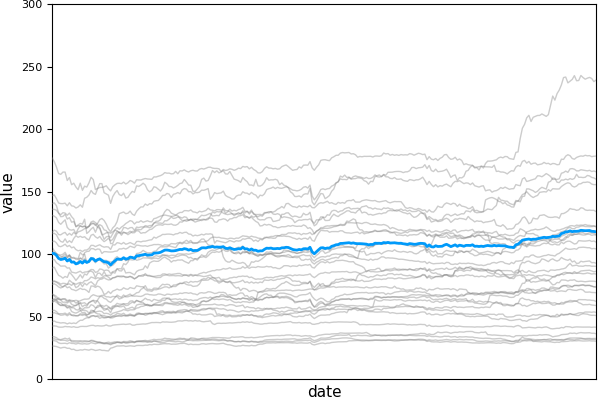

In [19]:
with(grid=false, legend=false, xticks=false, ylim=(0,300)) do
    plot(df, :date, :price, group=:symbol, c=:grey, alpha=0.4)
    plot!(index, :date, :value, linewidth=2)
end


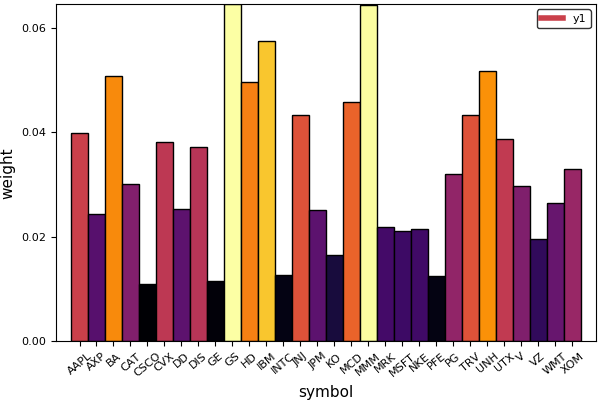

In [20]:
bar(weights, :symbol, :weight, xrotation=40, color=:weight, grid=false)

## Picking stocks

In [21]:
using JuMP # modeling
using Cbc  # solver backend

In [22]:
syms = [Symbol(s) for s in weights[:symbol]]
days = 1:length(prices[:date])

@show size(syms) size(days);

size(syms) = (30,)
size(days) = (252,)


In [23]:
function find_fund(maxstocks; timelimit=10.0, gaplimit=0.01, lastday=200)
    days = 1:lastday

    fund = Model(solver=CbcSolver(seconds=timelimit, ratioGap=gaplimit))

    # decisions
    @variable(fund, pick[syms], Bin)       # is stock included?
    @variable(fund, fraction[syms] ≥ 0)    # what part of the portfolio

    # auxiliary variables
    @variable(fund, Δ⁺[days] ≥ 0) # positive slack
    @variable(fund, Δ⁻[days] ≥ 0) # negative slack

    # fit to Dow Jones index
    for d in days
        @constraint(fund, sum(prices[d,s] * fraction[s] for s in syms) == index[d, :value] + Δ⁺[d] - Δ⁻[d])
    end

    # can only use stock if picked
    for s in syms
        @constraint(fund, fraction[s] ≤ pick[s])
    end
                
    # few stocks allowed
    @constraint(fund, sum(pick[s] for s in syms) ≤ maxstocks)

    # (why do we total to 1?)                            
    @constraint(fund, sum(fraction[s] for s in syms) == 1.0)
                            
    # minimize the absolute violation (L1 norm)
    @objective(fund, :Min, sum(Δ⁺[d] + Δ⁻[d] for d in days))
                            
                            
    status = solve(fund)
    @show status
    
    getvalue(fraction)
end

find_fund (generic function with 1 method)

In [24]:
sol = find_fund(3, timelimit=5, lastday=100)

status = :UserLimit


fraction: 1 dimensions:
[AAPL] = 0.1748671424836071
[ AXP] = 0.0
[  BA] = 0.0
[ CAT] = 0.0
[CSCO] = 0.0
[ CVX] = 0.0
[  DD] = 0.0
[ DIS] = 0.0
[  GE] = 0.0
[  GS] = 0.0
[  HD] = 0.31405194197773795
[ IBM] = 0.0
[INTC] = 0.0
[ JNJ] = 0.0
[ JPM] = 0.0
[  KO] = 0.0
[ MCD] = 0.0
[ MMM] = 0.0
[ MRK] = 0.0
[MSFT] = 0.0
[ NKE] = 0.0
[ PFE] = 0.0
[  PG] = 0.0
[ TRV] = 0.0
[ UNH] = 0.0
[ UTX] = 0.0
[   V] = 0.0
[  VZ] = 0.0
[ WMT] = 0.0
[ XOM] = 0.511080915538655

In [25]:
solfund = sum(sol[s] * prices[:, s] for s in syms);


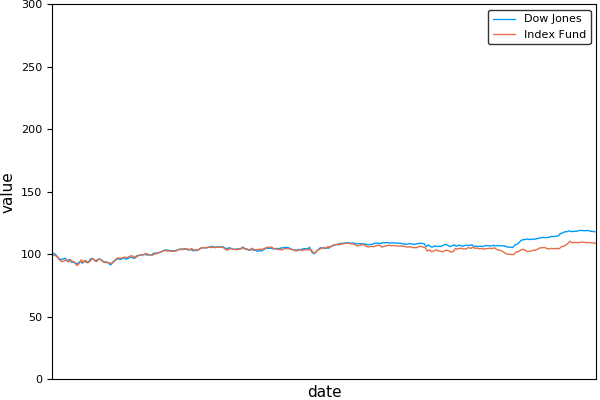

In [26]:
with(grid=false, xticks=false, ylim=(0,300)) do
    plot(index, :date, :value, label="Dow Jones")
    plot!(solfund, label="Index Fund")
end